**DATA EXTRACTION [ API ]**

**BLUEKSY EXTRACTION**

In [ ]:
import requests
import csv

BS_API_KEY = "a1b2c3d4-e5f6-7890-g1h2-i3j4k5l6m7n8"
BS_API_URL = "https://api.blueskyapp.com/v1/endpoint"

# Headers for the request
headers = {
    "Authorization": f"Bearer {BS_API_KEY}",
    "Content-Type": "application/json",
}

# Function to scrape Bluesky posts
def scrape_bluesky(query, max_posts, output_file):
    try:
        # Open CSV file for writing
        with open(output_file, mode="w", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            writer.writerow([
                "user_id", "user_created_at", "length", "likes", "quotes",
                "replies", "retweets", "text", "user_followers", "user_tweet_count"
            ])


            url = f"{BS_API_URL}posts/search"
            params = {
                "query": query,
                "limit": max_posts
            }
            response = requests.get(url, headers=headers, params=params)


            if response.status_code != 200:
                return

            data = response.json()

            # Loop through posts and write to CSV
            for post in data.get('posts', []):
                writer.writerow([
                    post['author']['did'],  # user_id
                    post['author']['created_at'],  # user_created_at
                    len(post['text']),  # length of post text
                    post['like_count'],  # likes
                    post['quote_count'],  # quotes
                    post['reply_count'],  # replies
                    post['repost_count'],  # retweets (reposts in Bluesky)
                    post['text'],  # text of the post
                    post['author']['followers_count'],  # user_followers
                    post['author']['post_count']  # user_tweet_count
                ])
    except:
        pass
scrape_bluesky(query="cultural moments", max_posts=100, output_file="bs_dataset.csv")


**TWITTER EXTRACTION**

In [ ]:
import tweepy
import csv

API_KEY = "x1y2z3a4b5c6d7e8f9g0h1i2j3k4l5m6"
API_SECRET_KEY = "n7o8p9q0r1s2t3u4v5w6x7y8z9a0b1c2"
ACCESS_TOKEN = "d3e4f5g6h7i8j9k0l1m2n3o4p5q6r7s8"
ACCESS_TOKEN_SECRET = "t9u0v1w2x3y4z5a6b7c8d9e0f1g2h3i4"

# Authenticate with the Twitter API
auth = tweepy.OAuthHandler(API_KEY, API_SECRET_KEY)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

# Function to scrape tweets and save to a CSV file
def scrape_twitter(query, max_tweets, output_file):
    try:
        # Open CSV file for writing
        with open(output_file, mode="w", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            writer.writerow([
                "tweet_created_at", "user_followers", "user_media_count", "user_tweet_count",
                "length", "hashtags", "users_mentioned", "likes", "quotes", "replies",
                "retweets", "text"
            ])

            # Fetch tweets using the Twitter API
            for tweet in tweepy.Cursor(api.search_tweets, q=query, lang="en", tweet_mode="extended").items(max_tweets):
                hashtags = [hashtag['text'] for hashtag in tweet.entities.get('hashtags', [])]
                users_mentioned = [mention['screen_name'] for mention in tweet.entities.get('user_mentions', [])]

                writer.writerow([
                    tweet.created_at,  # tweet_created_at
                    tweet.user.followers_count,  # user_followers
                    tweet.user.media_count,  # user_media_count
                    tweet.user.statuses_count,  # user_tweet_count
                    len(tweet.full_text),  # length of tweet text
                    hashtags,  # hashtags
                    users_mentioned,  # users_mentioned
                    tweet.favorite_count,  # likes
                    tweet.quote_count,  # quotes
                    tweet.reply_count,  # replies
                    tweet.retweet_count,  # retweets
                    tweet.full_text  # text of the tweet
                ])
    except:
        pass

scrape_twitter(query="Current political debates", max_tweets=100, output_file="tweets_main.csv")


**DATA PREPROCESSING**

In [ ]:
import pandas as pd

# Load data
bs_data = pd.read_csv('/content/bs_dataset.csv')
tw_data = pd.read_csv('/content/tweets_main.csv')

# Sort data by `user_created_at`
bs_data.sort_values(by='user_created_at', inplace=True)
tw_data.sort_values(by='user_created_at', inplace=True)

missing_values = pd.concat([bs_data.isna().sum(), tw_data.isna().sum()], axis=1)
missing_values.columns = ['bs_data_missing', 'tw_data_missing']
print(missing_values)


                  bs_data_missing  tw_data_missing
user_id                       0.0              358
user_created_at               0.0                0
length                        0.0                0
likes                         0.0                0
quotes                        0.0                0
replies                       0.0                0
retweets                      0.0                0
text                         12.0                0
user_followers                0.0                0
user_tweet_count              0.0                0
user_media_count              NaN                0
hashtags                      NaN                0
users_mentioned               NaN                0


In [ ]:
data_types = pd.concat([bs_data.dtypes, tw_data.dtypes], axis=1)
data_types.columns = ['bs_data_dtypes', 'tw_data_dtypes']
print(data_types)


                 bs_data_dtypes tw_data_dtypes
user_id                  object         object
user_created_at          object         object
length                    int64          int64
likes                     int64          int64
quotes                    int64          int64
replies                   int64          int64
retweets                  int64          int64
text                     object         object
user_followers           object          int64
user_tweet_count         object          int64
user_media_count            NaN          int64
hashtags                    NaN          int64
users_mentioned             NaN          int64


In [ ]:
unique_values = pd.concat([bs_data.nunique(), tw_data.nunique()], axis=1)
unique_values.columns = ['bs_data_unique', 'tw_data_unique']
print(unique_values)


                  bs_data_unique  tw_data_unique
user_id                    467.0            1383
user_created_at            187.0            1204
length                     246.0             288
likes                      621.0            2895
quotes                     123.0             815
replies                    256.0            1291
retweets                   376.0            2197
text                       657.0            2973
user_followers             619.0            2913
user_tweet_count           441.0            2235
user_media_count             NaN            2030
hashtags                     NaN               9
users_mentioned              NaN               7


In [ ]:
print(bs_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 672 entries, 564 to 404
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           672 non-null    object
 1   user_created_at   672 non-null    object
 2   length            672 non-null    int64 
 3   likes             672 non-null    int64 
 4   quotes            672 non-null    int64 
 5   replies           672 non-null    int64 
 6   retweets          672 non-null    int64 
 7   text              660 non-null    object
 8   user_followers    672 non-null    object
 9   user_tweet_count  672 non-null    object
dtypes: int64(5), object(5)
memory usage: 57.8+ KB
None


In [ ]:
print(tw_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3043 entries, 2493 to 1546
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_created_at   3043 non-null   object
 1   user_followers    3043 non-null   int64 
 2   user_media_count  3043 non-null   int64 
 3   user_tweet_count  3043 non-null   int64 
 4   length            3043 non-null   int64 
 5   hashtags          3043 non-null   int64 
 6   users_mentioned   3043 non-null   int64 
 7   likes             3043 non-null   int64 
 8   quotes            3043 non-null   int64 
 9   replies           3043 non-null   int64 
 10  retweets          3043 non-null   int64 
 11  text              3043 non-null   object
 12  user_id           2685 non-null   object
dtypes: int64(10), object(3)
memory usage: 332.8+ KB
None


In [ ]:
# checking duplicates
def check_duplicates(bs_data, tw_data):
    duplicates = pd.DataFrame({
        'bs_data_duplicates': [bs_data.duplicated().sum()],
        'tw_data_duplicates': [tw_data.duplicated().sum()]
    })
    return duplicates

duplicates = check_duplicates(bs_data, tw_data)

print("Duplicates in datasets:")
print(duplicates)

Duplicates in datasets:
   bs_data_duplicates  tw_data_duplicates
0                   0                   0


In [ ]:
# Save processed data
bs_data.to_csv('/content/bs_dataset.csv', index=False)
tw_data.to_csv('/content/tweets_main.csv', index=False)

**DATA VISUALISATION**

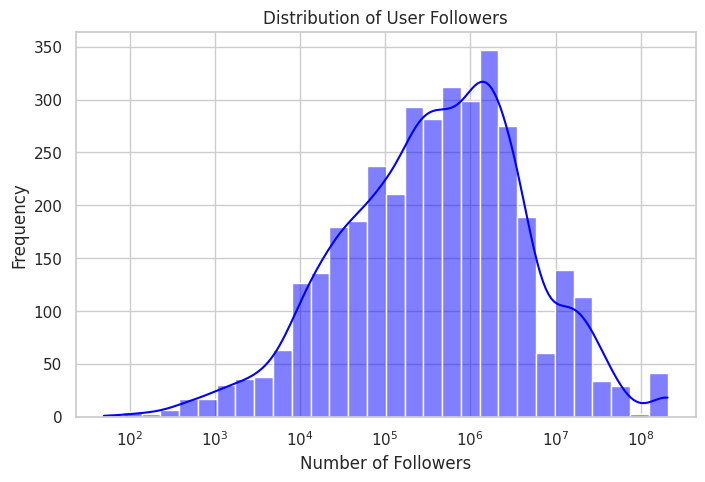

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine datasets for platform comparison
bs_data['platform'] = 'BlueSky'
tw_data['platform'] = 'Twitter'
data = pd.concat([bs_data, tw_data], ignore_index=True)
sns.set(style="whitegrid", palette="muted")
data['user_followers'] = pd.to_numeric(data['user_followers'], errors='coerce')
data = data.dropna(subset=['user_followers'])

# Plot Distribution of User Followers
plt.figure(figsize=(8, 5))
sns.histplot(data['user_followers'], bins=30, kde=True, log_scale=True, color='blue')
plt.title('Distribution of User Followers')
plt.xlabel('Number of Followers')
plt.ylabel('Frequency')
plt.show()




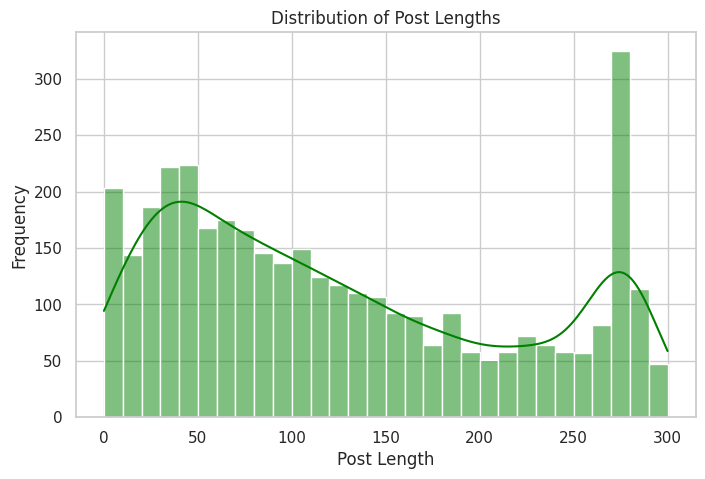

In [ ]:
# 2. Distribution of Post Lengths
plt.figure(figsize=(8, 5))
sns.histplot(data['length'], bins=30, kde=True, color='green')
plt.title('Distribution of Post Lengths')
plt.xlabel('Post Length')
plt.ylabel('Frequency')
plt.show()

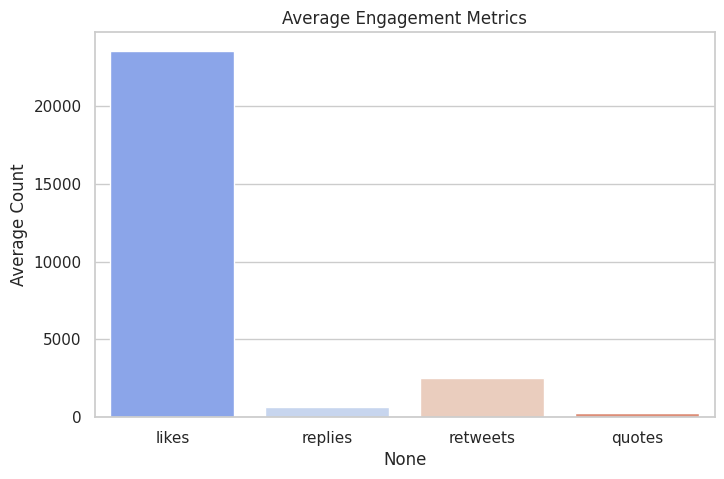

In [ ]:
# 3. Engagement Summary
plt.figure(figsize=(8, 5))
sns.barplot(x=engagement_means.index, y=engagement_means.values, hue=engagement_means.index, palette="coolwarm", legend=False)
plt.title('Average Engagement Metrics')
plt.ylabel('Average Count')
plt.show()


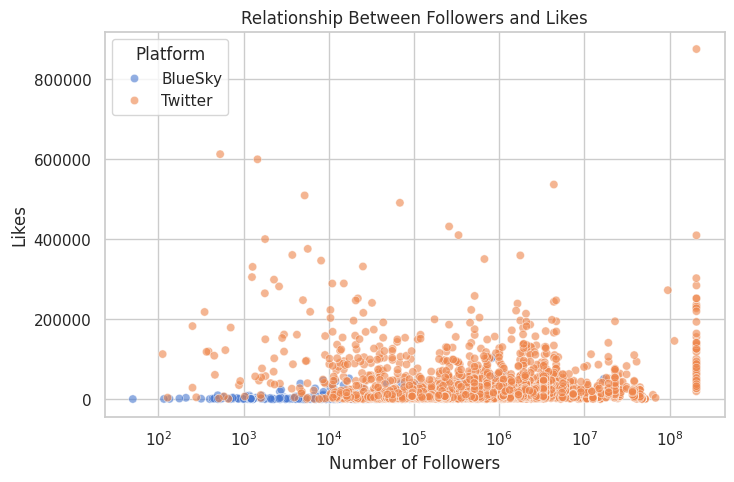

In [ ]:
# 4. Relationship Between Followers and Likes
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data['user_followers'], y=data['likes'], hue=data['platform'], alpha=0.6)
plt.xscale('log')
plt.title('Relationship Between Followers and Likes')
plt.xlabel('Number of Followers')
plt.ylabel('Likes')
plt.legend(title='Platform')
plt.show()

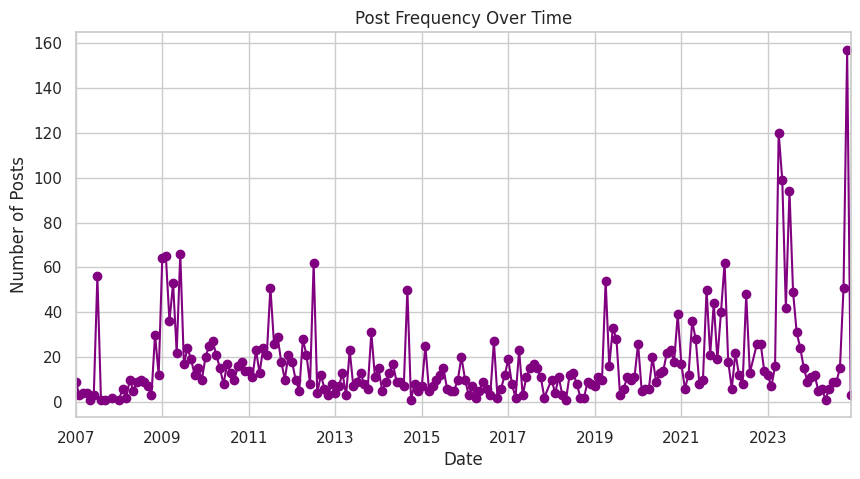

In [ ]:
# 5. Post Frequency Over Time
data['user_created_at'] = pd.to_datetime(data['user_created_at'])
post_freq = data.groupby(data['user_created_at'].dt.to_period('M')).size()
plt.figure(figsize=(10, 5))
post_freq.plot(kind='line', marker='o', color='purple')
plt.title('Post Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

<Figure size 1000x500 with 0 Axes>

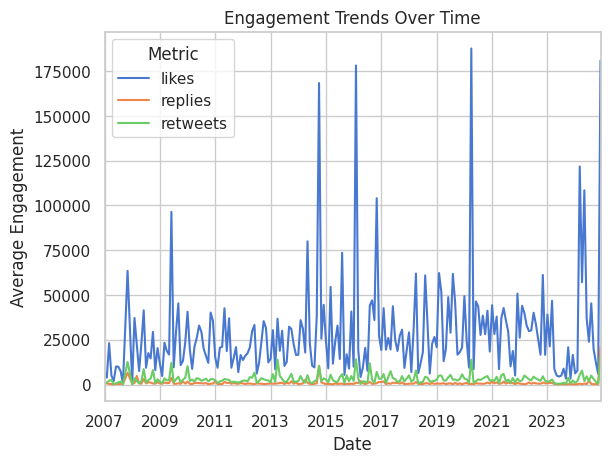

In [ ]:
# 6. Engagement Trends Over Time
engagement_over_time = data.groupby(data['user_created_at'].dt.to_period('M'))[['likes', 'replies', 'retweets']].mean()
plt.figure(figsize=(10, 5))
engagement_over_time.plot()
plt.title('Engagement Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Average Engagement')
plt.legend(title='Metric')
plt.show()

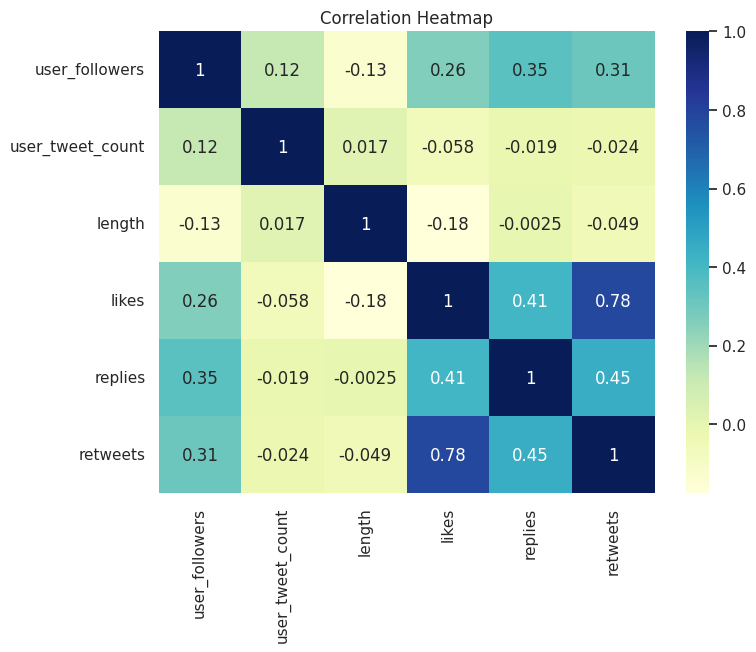

In [ ]:
# 7. Correlation Heatmap
plt.figure(figsize=(8, 6))
# Convert specified columns to numeric, handling errors by coercing to NaN
numeric_cols = ['user_followers', 'user_tweet_count', 'length', 'likes', 'replies', 'retweets']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Calculate correlation and drop rows with any NaN values
correlation_matrix = data[numeric_cols].corr().dropna(how='any')

sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap')
plt.show()

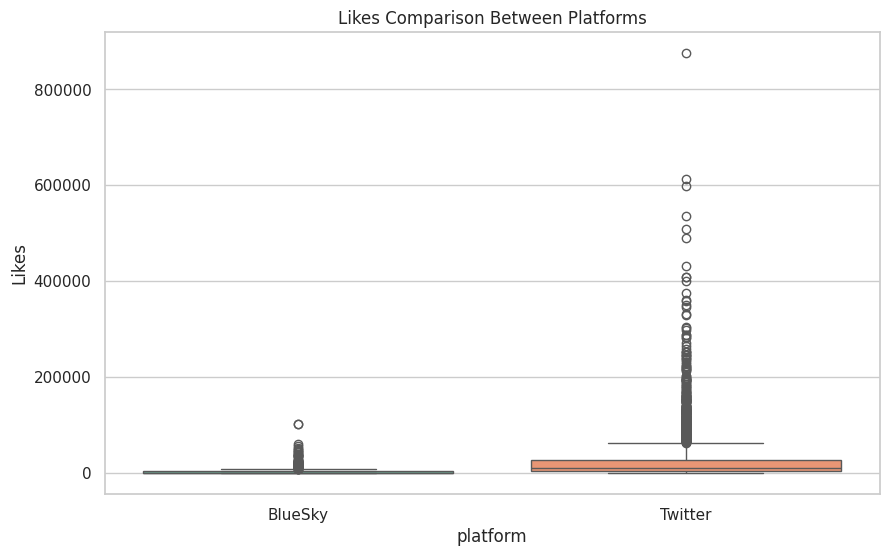

In [ ]:
# 8. BOXPLOT
plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='likes', data=data, hue='platform', palette='Set2', legend=False)
plt.title('Likes Comparison Between Platforms')
plt.ylabel('Likes')
plt.show()


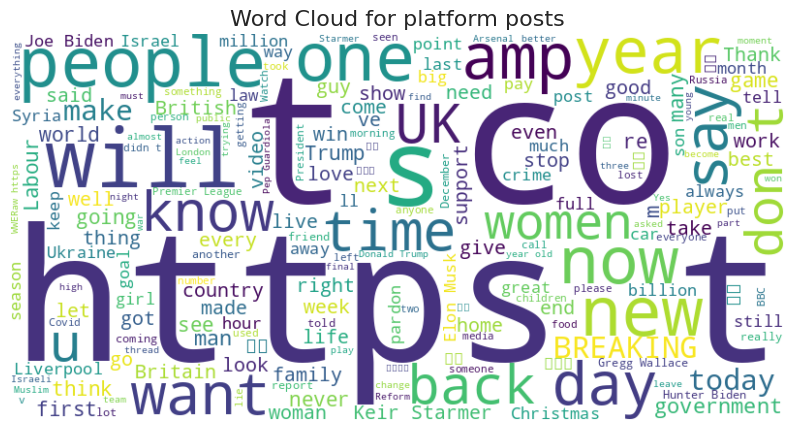

In [ ]:
#9. WORDMAP
from wordcloud import WordCloud

posts = tw_data['text'].dropna()
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(posts))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for platform posts', fontsize=16)
plt.show()


**SENTIMENT SCORES:**

In [ ]:
!pip install vaderSentiment



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each post in the 'text' column
tw_data['sentiment_score'] = tw_data['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


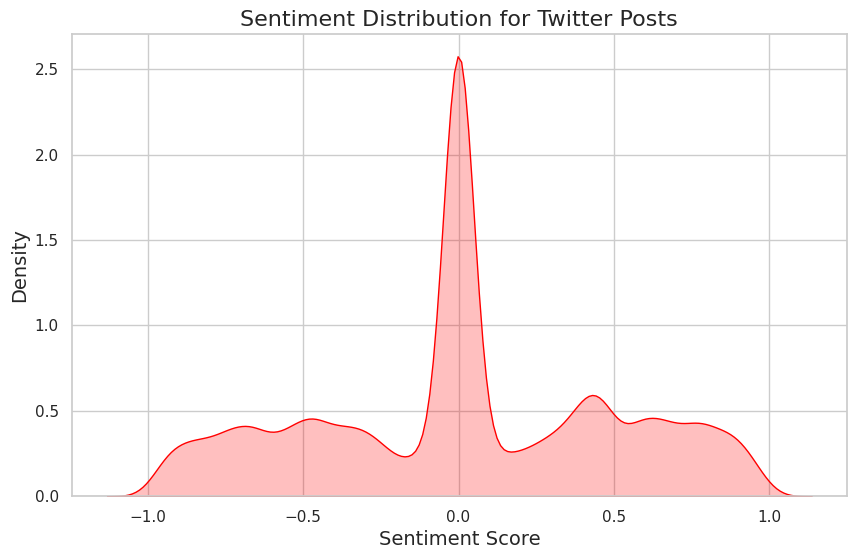

In [ ]:
# 10. SENTIMENT SCORE:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=tw_data['sentiment_score'], fill=True, color="red", bw_adjust=0.5)
plt.title('Sentiment Distribution for Twitter Posts', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()


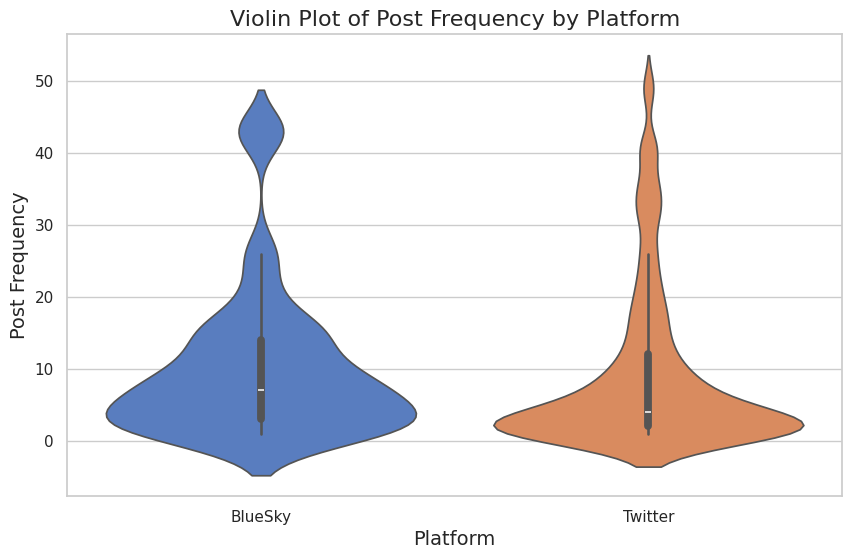

In [ ]:
#11. VIOLIN PLOT:
plt.figure(figsize=(10, 6))
sns.violinplot(x='platform', y='post_frequency', data=data, hue='platform', palette='muted', legend=False)
plt.title('Violin Plot of Post Frequency by Platform', fontsize=16)
plt.xlabel('Platform', fontsize=14)
plt.ylabel('Post Frequency', fontsize=14)
plt.show()


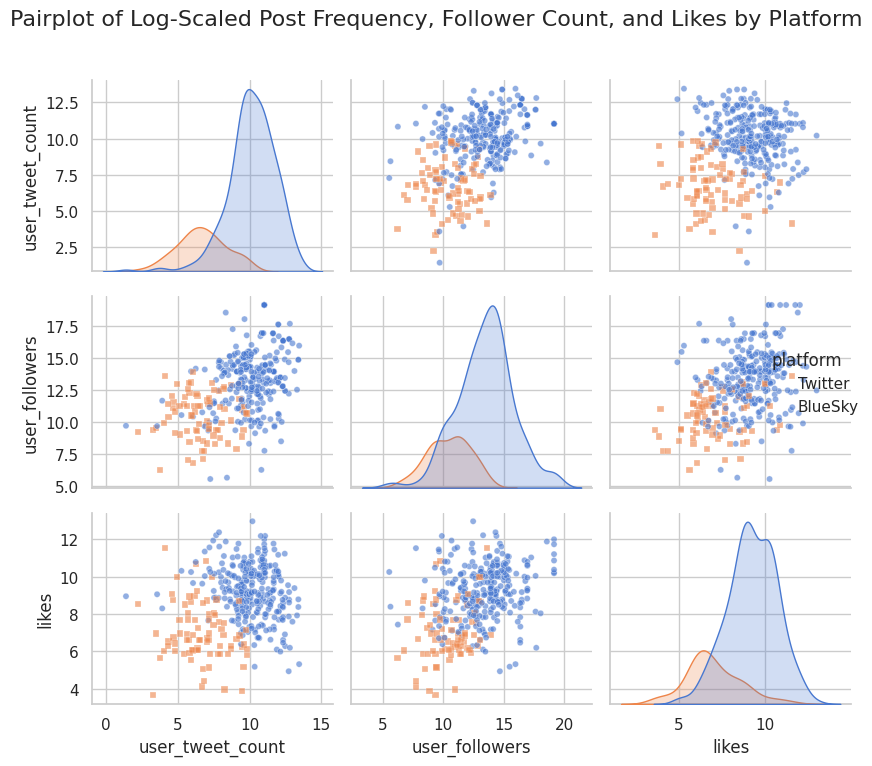

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Subsample the data for better visibility (optional, adjust as needed)
sample_data = data.sample(frac=0.1, random_state=42)  # Use 10% of the data

# Ensure numeric data and handle missing values
log_data = sample_data.copy()
for col in ['user_tweet_count', 'user_followers', 'likes']:
    # Convert to numeric and fill missing/invalid values with 0
    log_data[col] = pd.to_numeric(log_data[col], errors='coerce').fillna(0)

    # Clip negative values to 0 (if any exist)
    log_data[col] = log_data[col].clip(lower=0)

    # Apply log transformation
    log_data[col] = np.log1p(log_data[col])

# Pairplot with improved layout
sns.pairplot(log_data[['user_tweet_count', 'user_followers', 'likes', 'platform']],
             hue='platform',
             palette='muted',
             markers=['o', 's'],
             plot_kws={'alpha': 0.6, 's': 20})  # Adjust alpha and marker size

# Add titles and adjust spacing
plt.suptitle('Pairplot of Log-Scaled Post Frequency, Follower Count, and Likes by Platform',
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


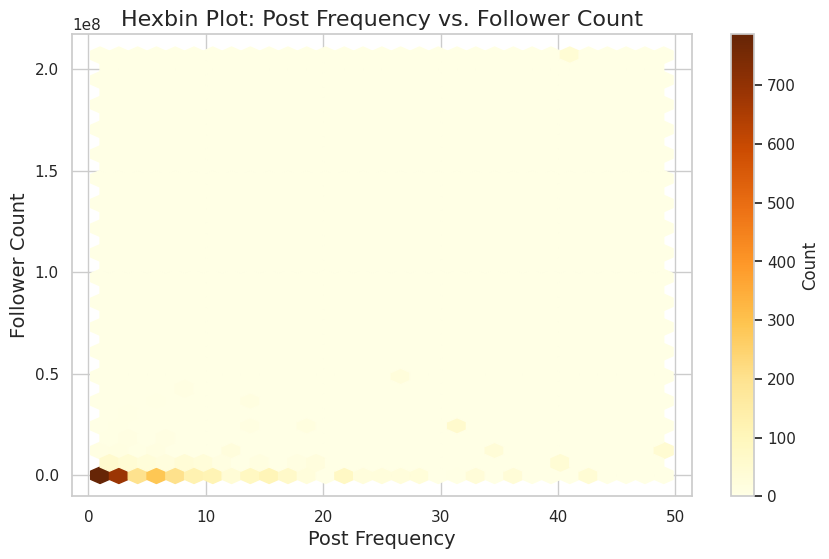

In [ ]:
#13. HEXBIN PLOT
plt.figure(figsize=(10, 6))
plt.hexbin(data['post_frequency'], data['user_followers'], gridsize=30, cmap='YlOrBr')
plt.colorbar(label='Count')
plt.title('Hexbin Plot: Post Frequency vs. Follower Count', fontsize=16)
plt.xlabel('Post Frequency', fontsize=14)
plt.ylabel('Follower Count', fontsize=14)
plt.show()


**VIRALITY INDEX**

In [ ]:
def calculate_virality_index(data):
    data['user_id'] = data['user_created_at']
    data['post_id'] = data.index

    # Define weights for the Virality Index
    alpha, beta, gamma, delta, eta = 1, 1, 1, 0.5, 2

    # Calculate post frequency per user
    post_frequency = data.groupby('user_id')['post_id'].transform('count')

    # Add post frequency to the dataset
    data['post_frequency'] = post_frequency

    # Compute the Virality Index
    data['virality_index'] = (
        alpha * data['likes'] +
        beta * data['replies'] +
        gamma * data['retweets'] +
        delta * data['quotes'] +
        eta * data['post_frequency']
    )

    return data

# Apply to both datasets
tw_data = calculate_virality_index(tw_data)
bs_data = calculate_virality_index(bs_data)

# Optionally, view the results
print(tw_data[['user_id', 'post_id', 'virality_index']].head())
print(bs_data[['user_id', 'post_id', 'virality_index']].head())

tw_data.to_csv('/content/tweets_main_with_virality.csv', index=False)
bs_data.to_csv('/content/mikhail_bs_dataset_with_virality.csv', index=False)

      user_id  post_id  virality_index
0  2007-01-02        0          3579.5
1  2007-01-02        1         14542.5
2  2007-01-08        2          1689.0
3  2007-01-08        3           269.0
4  2007-01-08        4         46641.0
      user_id  post_id  virality_index
0  2023-04-10        0          1839.0
1  2023-04-12        1         57406.0
2  2023-04-14        2          4026.5
3  2023-04-15        3          6667.0
4  2023-04-19        4         18550.0


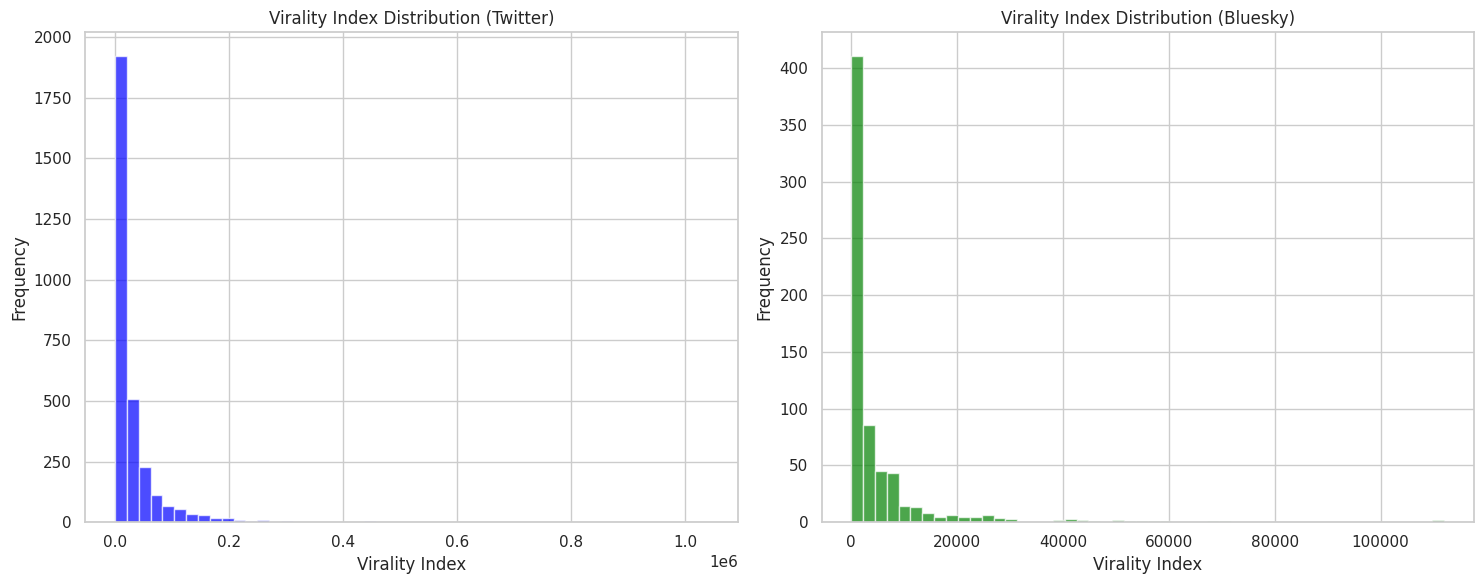

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Twitter virality index distribution
ax[0].hist(tw_data['virality_index'], bins=50, alpha=0.7, color='blue')
ax[0].set_title('Virality Index Distribution (Twitter)')
ax[0].set_xlabel('Virality Index')
ax[0].set_ylabel('Frequency')

# Bluesky virality index distribution
ax[1].hist(bs_data['virality_index'], bins=50, alpha=0.7, color='green')
ax[1].set_title('Virality Index Distribution (Bluesky)')
ax[1].set_xlabel('Virality Index')
ax[1].set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


**MODEL IMPLEMENTATION**

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the dataset (assuming 'data' is already prepared)
# Separate features (predictor variables) and target variable (Virality Index)
X = data[['likes', 'replies', 'retweets', 'quotes', 'post_frequency', 'length']]  # Example features
y = data['virality_index']  # Target variable: Virality Index

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models to evaluate
models = {
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor()
}

# Initialize dictionaries to store results
results = {'Model': [], 'MSE': [], 'MAE': [], 'R2': []}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results['Model'].append(model_name)
    results['MSE'].append(mse)
    results['MAE'].append(mae)
    results['R2'].append(r2)

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Display the comparison of models
print(results_df)


               Model           MSE           MAE        R2
0            XGBoost  8.185881e+07  1.249886e+03  0.973816
1      Random Forest  2.192743e+07  9.146685e+02  0.992986
2  Linear Regression  8.698117e-22  1.757309e-11  1.000000
3                SVR  3.375013e+09  2.269788e+04 -0.079544
4  Gradient Boosting  8.818432e+06  7.443625e+02  0.997179
5                KNN  3.567160e+07  9.435187e+02  0.988590


**OTHER EVALUATION METRICS**   
 [turning continuous predictions into discrete categories (e.g., high, medium, low)]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Define classes based on virality index thresholds
def classify_virality(value):
    low_threshold = y_train.quantile(0.33)
    high_threshold = y_train.quantile(0.66)
    if value < 0.2:
        return 'Low'
    elif value < 0.5:
        return 'Medium'
    else:
        return 'High'

# Convert continuous y_test and y_pred to discrete categories
y_test_classified = y_test.apply(classify_virality)
y_pred_classified = pd.Series(y_pred).apply(classify_virality)

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test_classified, y_pred_classified))



Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       743

    accuracy                           1.00       743
   macro avg       1.00      1.00      1.00       743
weighted avg       1.00      1.00      1.00       743



In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_classified, y_pred_classified, labels=['Low', 'Medium', 'High']))

Confusion Matrix:
[[  0   0   0]
 [  0   0   0]
 [  0   0 743]]


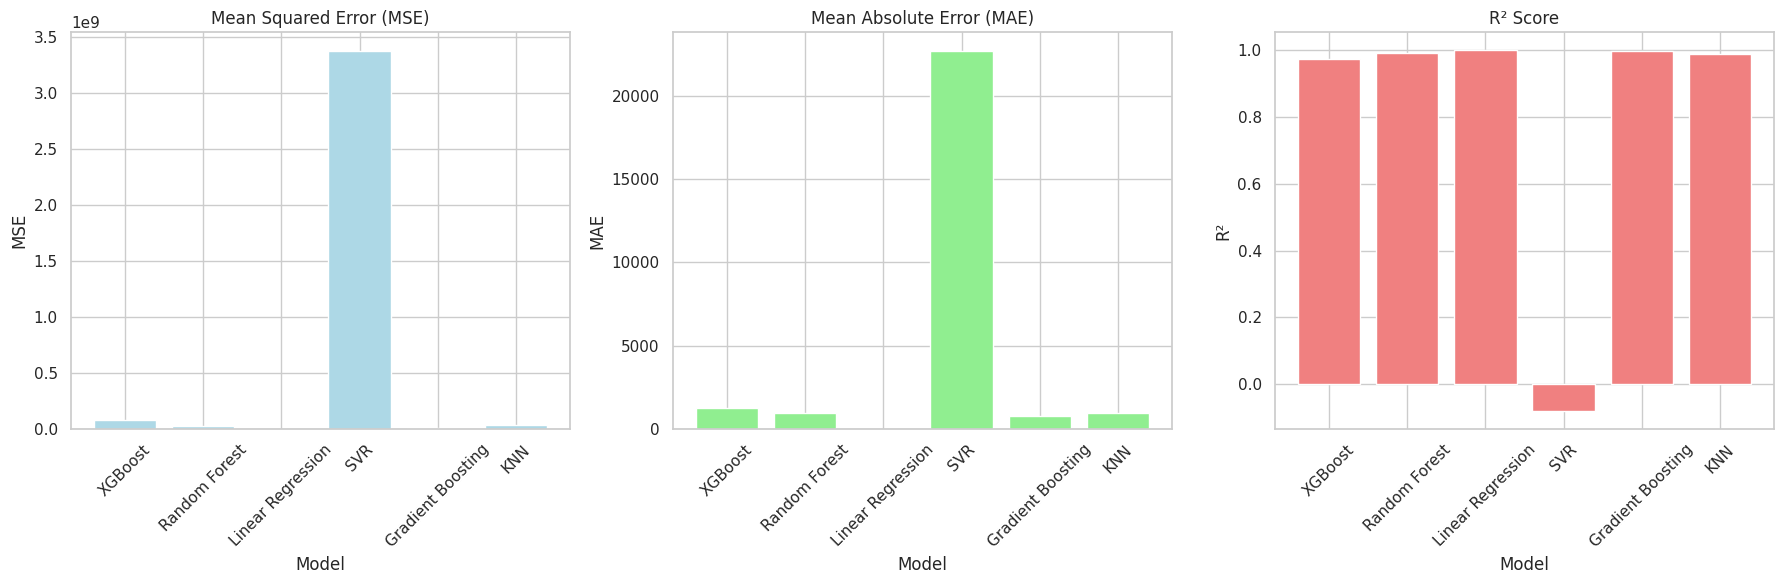

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot MSE, MAE, and R² for all models
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Plot MSE
axes[0].bar(results_df['Model'], results_df['MSE'], color='lightblue')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45)

# Plot MAE
axes[1].bar(results_df['Model'], results_df['MAE'], color='lightgreen')
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# Plot R² Score
axes[2].bar(results_df['Model'], results_df['R2'], color='lightcoral')
axes[2].set_title('R² Score')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


**HYPERPARAMETER TUNING**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameters grid for Random Forest
rf_param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': np.arange(5, 21, 1),
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(1, 11, 1),
    'bootstrap': [True, False]
}

# Perform RandomizedSearchCV for Random Forest
rf_rand_search = RandomizedSearchCV(rf_model, param_distributions=rf_param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=2, random_state=42)
rf_rand_search.fit(X_train, y_train)

# Get the best Random Forest model and its parameters
best_rf_model = rf_rand_search.best_estimator_
best_rf_params = rf_rand_search.best_params_

# Output the best model and hyperparameters
print("Best Random Forest Model:", best_rf_model)
print("Best Hyperparameters for Random Forest:", best_rf_params)

# Define the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Define the hyperparameters grid for Gradient Boosting
gb_param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': np.arange(3, 11, 1),
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': np.arange(2, 11, 1)
}

# Perform RandomizedSearchCV for Gradient Boosting
gb_rand_search = RandomizedSearchCV(gb_model, param_distributions=gb_param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=2, random_state=42)
gb_rand_search.fit(X_train, y_train)

# Get the best Gradient Boosting model and its parameters
best_gb_model = gb_rand_search.best_estimator_
best_gb_params = gb_rand_search.best_params_

# Output the best model and hyperparameters
print("Best Gradient Boosting Model:", best_gb_model)
print("Best Hyperparameters for Gradient Boosting:", best_gb_params)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Random Forest Model: RandomForestRegressor(bootstrap=False, max_depth=15, min_samples_leaf=3,
                      min_samples_split=9, n_estimators=500, random_state=42)
Best Hyperparameters for Random Forest: {'n_estimators': 500, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 15, 'bootstrap': False}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Gradient Boosting Model: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_split=10,
                          n_estimators=400, random_state=42, subsample=0.9)
Best Hyperparameters for Gradient Boosting: {'subsample': 0.9, 'n_estimators': 400, 'min_samples_split': 10, 'max_depth': 5, 'learning_rate': 0.2}


**PCA**

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reducing to 2 components for visualization, adjust as necessary
X_pca = pca.fit_transform(X)

# Split the PCA-transformed data into training and test sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize dictionaries to store results
results_pca = {'Model': [], 'MSE': [], 'MAE': [], 'R2': []}

# Train and evaluate each model using PCA-transformed data
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = model.predict(X_test_pca)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results_pca['Model'].append(model_name)
    results_pca['MSE'].append(mse)
    results_pca['MAE'].append(mae)
    results_pca['R2'].append(r2)

# Convert results to DataFrame for easy comparison
results_pca_df = pd.DataFrame(results_pca)

# Display the comparison of models
print(results_pca_df)

               Model           MSE           MAE        R2
0            XGBoost  1.211875e+08   1608.303874  0.961237
1      Random Forest  1.438215e+07   1004.628970  0.995400
2  Linear Regression  1.297768e+06    555.548528  0.999585
3                SVR  3.373858e+09  22679.393474 -0.079175
4  Gradient Boosting  1.035525e+07    953.592615  0.996688
5                KNN  3.583853e+07   1119.658546  0.988537


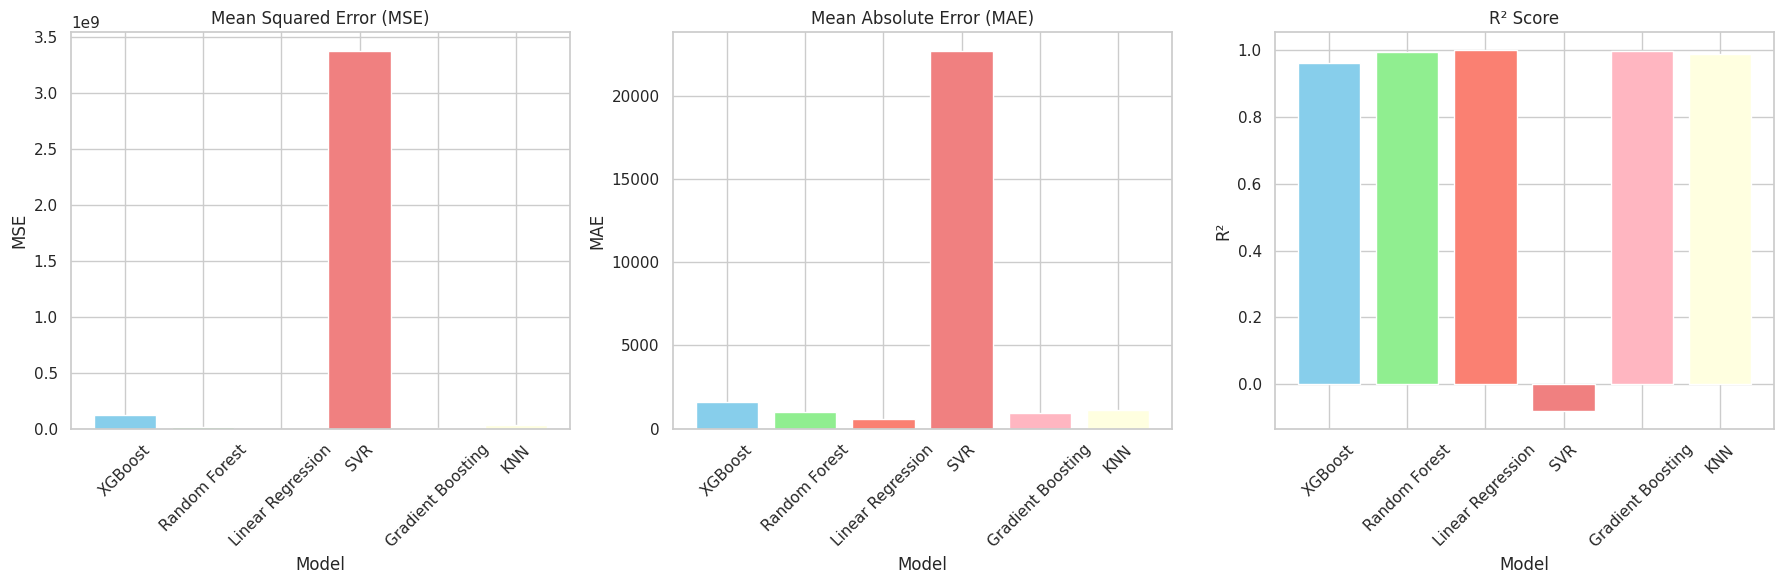

In [ ]:
# Improved plotting with spacing, colors, and rotated labels
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Colors for each model
colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'lightpink', 'lightyellow']

# MSE plot
axes[0].bar(results_pca_df['Model'], results_pca_df['MSE'], color=colors)
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45)

# MAE plot
axes[1].bar(results_pca_df['Model'], results_pca_df['MAE'], color=colors)
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# R² plot
axes[2].bar(results_pca_df['Model'], results_pca_df['R2'], color=colors)
axes[2].set_title('R² Score')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout for spacing
plt.tight_layout()
plt.show()


**FEATURE SELECTION**

**1. SHAP**

In [ ]:
pip install shap


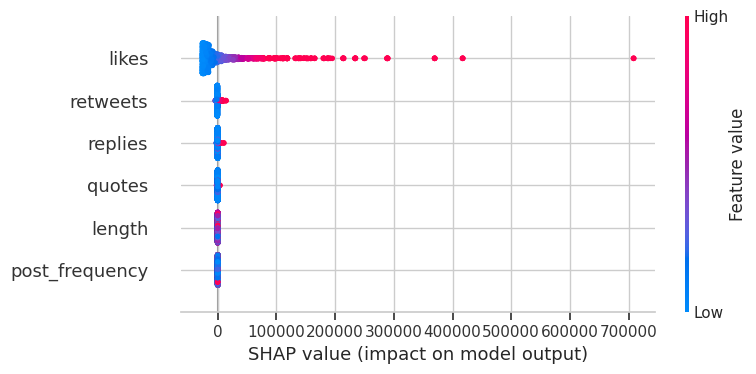

In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# Plot summary of SHAP values (global feature importance)
shap.summary_plot(shap_values, X_train)


**2. FEATURE IMPORTANCE**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)
feature_importances = rf_model.feature_importances_

# Create a DataFrame for features and their importances
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

top_n = 5  # You can adjust this number
selected_features = features_df['Feature'][:top_n].values

# Filter the dataset based on selected features
X_selected = X[selected_features]

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train a new model with the selected features
rf_model_selected = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_selected.fit(X_train, y_train)

# Make predictions
y_pred_selected = rf_model_selected.predict(X_test)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred_selected)
mae = mean_absolute_error(y_test, y_pred_selected)
r2 = r2_score(y_test, y_pred_selected)

print(f"Selected Features Model Performance:\nMSE: {mse}\nMAE: {mae}\nR2: {r2}")


Selected Features Model Performance:
MSE: 18968682.826030795
MAE: 868.7666150740243
R2: 0.9939326055940045


          Feature  Importance
0           likes    0.967487
3          quotes    0.016195
2        retweets    0.010051
1         replies    0.003978
5          length    0.001180
4  post_frequency    0.001108


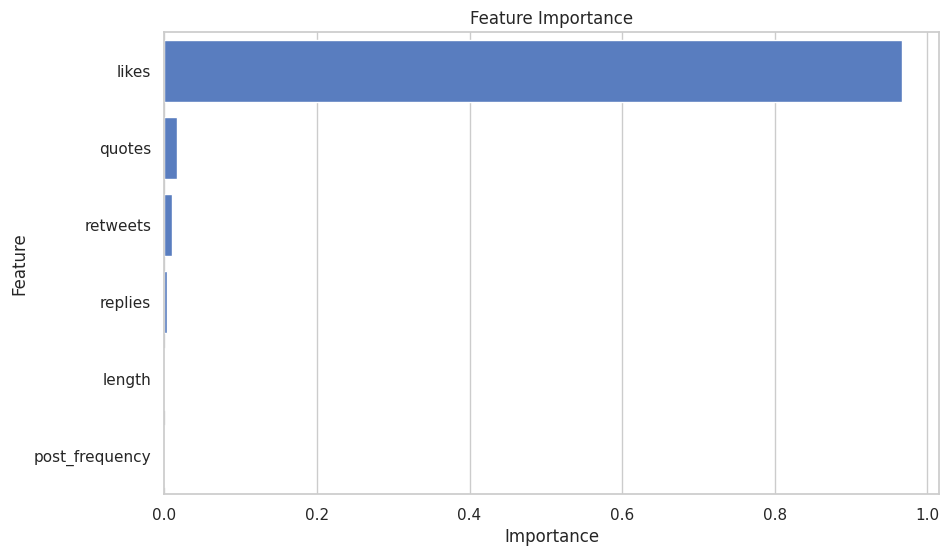

In [ ]:
# Get the feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
print(features_df)

# Plot the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance')
plt.show()


**VISUALISATION FOR MODEL INSIGHTS**

**Interactive Feature Importance Visualization (Using Plotly):**

In [ ]:
import plotly.express as px
import pandas as pd

feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

fig = px.bar(feature_importance_df,
             x='Feature',
             y='Importance',
             title='Interactive Feature Importance (Random Forest)',
             labels={'Feature': 'Feature', 'Importance': 'Importance'},
             color='Importance', color_continuous_scale='Viridis')

fig.show()


**Prediction vs Actual with Hover Effects (Interactive Plotly Scatter Plot):**

In [ ]:
# Ensure the columns used in both training and testing are consistent
X = X[['likes', 'retweets', 'quotes', 'post_frequency', 'replies']]  # Excluding 'length'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make sure that both training and test sets use the same feature set
X_test = X_test[X_train.columns]

# Train the model
rf_model.fit(X_train, y_train)

# Generate predictions
y_pred = rf_model.predict(X_test)

In [ ]:
# Ensure the columns in X_test match X_train
X_test = X_test[X_train.columns]

# Generate predictions
y_pred = rf_model.predict(X_test)

# Create a DataFrame for actual vs predicted
prediction_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Create interactive scatter plot for Prediction vs Actual
fig = px.scatter(prediction_df,
                 x='Actual',
                 y='Predicted',
                 title="Prediction vs Actual",
                 labels={'Actual': 'Actual Virality', 'Predicted': 'Predicted Virality'},
                 hover_data={'Actual': True, 'Predicted': True})

fig.update_traces(marker=dict(size=8, color='blue', opacity=0.6, line=dict(width=0.5, color='black')))
fig.show()

**Interactive Residual Plot (Residuals vs Predicted, Plotly):**

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Create a DataFrame for residuals vs predicted values
residual_df = pd.DataFrame({
    'Predicted': y_pred,
    'Residuals': residuals
})

# Create interactive residual plot for Residuals vs Predicted
fig_residual = px.scatter(residual_df,
                          x='Predicted',
                          y='Residuals',
                          title="Residuals vs Predicted",
                          labels={'Predicted': 'Predicted Virality', 'Residuals': 'Residuals'},
                          hover_data={'Predicted': True, 'Residuals': True})

fig_residual.update_traces(marker=dict(size=8, color='red', opacity=0.6, line=dict(width=0.5, color='black')))
fig_residual.show()

**Analysing Causal Connections via Dynamic Network Models**

In [ ]:
import random


In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

class SocialMediaAgent(Agent):
    """A simple agent representing a social media user."""
    def __init__(self, unique_id, model, post_length, sentiment_score):
        super().__init__(unique_id, model)
        self.post_length = post_length
        self.sentiment_score = sentiment_score
        self.popularity = 0  # Initial popularity (Virality Index)

    def step(self):
        # Hypothetical model: Popularity based on post length and sentiment
        self.popularity = self.sentiment_score / self.post_length  # Simplified mechanism

        # Update agent's popularity or interact with others

class SocialMediaModel(Model):
    """A model representing the social media network."""
    def __init__(self, num_agents):
        self.num_agents = num_agents
        self.grid = MultiGrid(10, 10, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            post_length = random.randint(50, 200)  # Example post length
            sentiment_score = random.uniform(0, 1)  # Example sentiment score
            a = SocialMediaAgent(i, self, post_length, sentiment_score)
            self.schedule.add(a)
            # Place agents on the grid
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        # Data collector to track the model state
        self.datacollector = DataCollector(
            agent_reporters={"Popularity": "popularity"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Create the model and run it
model = SocialMediaModel(100)
for i in range(100):  # Run for 100 steps
    model.step()

# Gather the data
popularity_data = model.datacollector.get_agent_vars_dataframe()
print(popularity_data)


              Popularity
Step AgentID            
0    0          0.000000
     1          0.000000
     2          0.000000
     3          0.000000
     4          0.000000
...                  ...
99   95         0.002857
     96         0.010746
     97         0.007435
     98         0.005878
     99         0.000824

[10000 rows x 1 columns]


In [ ]:
print(popularity_data.head())  # First 5 rows
print(popularity_data.tail())  # Last 5 rows


              Popularity
Step AgentID            
0    0               0.0
     1               0.0
     2               0.0
     3               0.0
     4               0.0
              Popularity
Step AgentID            
99   95         0.005614
     96         0.003639
     97         0.005015
     98         0.000479
     99         0.006269


In [ ]:
popularity_data.to_csv('popularity_data.csv')
print(popularity_data.describe())


         Popularity
count  10000.000000
mean       0.005222
std        0.003729
min        0.000000
25%        0.002819
50%        0.004731
75%        0.006920
max        0.016911
